# Otimização por Múltiplos Enxames Aplicada ao Escalonamento Dinâmico de Projetos de Software


### QP2. Como o desempenho do algoritmo proposto se compara ao de algoritmos da literatura quando aplicados ao DSPSP?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon, friedmanchisquare
import scikit_posthocs as sp

from dspsp_analysis import metrics_dataset

%matplotlib inline

pd.set_option('display.float_format', '{:.2E}'.format)

data = metrics_dataset(filepath="../hypervolume/metrics-all.csv")

In [2]:
def hv_mean(data, instance_id, algorithm_id, grouping="event"):
    df = data[(data.algorithm ==  algorithm_id) & (data.instance == instance_id)]
    df = df.groupby(["instance", "algorithm", grouping], as_index=False)["hypervolume"].mean()
    return df


def hv_measures(data, grouping="event", limit=None):
    instance_ids = list(data.instance.unique())
    algorithm_ids = list(data.algorithm.unique())
    measures = {}
    for inst in instance_ids:
        measures[inst] = {}
        for alg in algorithm_ids:
            measures[inst][alg] = hv_mean(data, inst, alg, grouping)[:limit]
    return measures


def mean_hypervolume(data):
    return data.groupby(["instance", "algorithm"], as_index=False)["hypervolume"].agg(['mean', 'std'])


def plot_hv(data, inst, algorithms):
    plt.title("Instância {} \n{}".format(inst, " x ".join(algorithms)))
    plt.xlabel("Pontos de reescalonamento")
    plt.ylabel("Hipervolume")
    for alg in algorithms:
        plt.plot(data[inst][alg].hypervolume, "-o", markersize=3, lw=.5)
    plt.legend(algorithms, loc="lower right")
    plt.show()
    

def boxplot_hv(data, inst, algorithms):
    plt.title("Instância {} \n{}".format(inst, " x ".join(algorithms)))
    plt.ylabel("Hipervolume")
    plt.boxplot([data[inst][alg].hypervolume for alg in algorithms], labels=algorithms)
    plt.show()
    

def combined_plot_hv(data, inst, algorithms):
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))
    f.suptitle("Instância {} \n{}".format(inst, " x ".join(algorithms)))

    for alg in algorithms:
        ax1.plot(data[inst][alg].hypervolume, "-o", markersize=3, lw=.5)
    ax1.set_xlabel("Pontos de reescalonamento")
    ax1.set_ylabel("Hipervolume")
    ax1.legend(algorithms, loc="lower right")

    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    ax2.boxplot([data[inst][alg].hypervolume for alg in algorithms], labels=algorithms)
    ax2.set_ylabel("Hipervolume")

    f.subplots_adjust(wspace=0.1, top=0.85)
    

In [3]:
mean_hv = mean_hypervolume(data).reset_index()
mean_hv.pivot(index='algorithm', columns='instance')

mean                                        \
instance  ST10_DT10_E15_SK4-5 ST10_DT10_E5_SK4-5 ST20_DT10_E5_SK4-5   
algorithm                                                             
MS2MO                1.07E+00           7.90E-01           1.03E+00   
MS2MO-C              8.29E-01           6.13E-01           8.65E-01   
MS2MO-H              8.34E-01           5.88E-01           7.70E-01   
MS2MO-P              7.40E-01           5.93E-01           8.49E-01   
NSGAII               9.63E-01           6.84E-01           8.85E-01   
NSGAII-D             8.71E-01           6.96E-01           1.00E+00   
SMPSO                1.18E+00           9.75E-01           1.17E+00   
SMPSO-D              1.34E+00           1.06E+00           1.16E+00   

                          std                                        
instance  ST10_DT10_E15_SK4-5 ST10_DT10_E5_SK4-5 ST20_DT10_E5_SK4-5  
algorithm                                                            
MS2MO                1.56E-01           4.86E-01           2.63E-01  
MS2MO-C              2.03E-01           4.01E-01           2.64E-01  
MS2MO-H              1.84E-01           3.98E-01           2.42E-01  
MS2MO-P              2.20E-01           3.98E-01           2.92E-01  
NSGAII               1.59E-01           4.22E-01           2.44E-01  
NSGAII-D             2.42E-01           4.44E-01           2.78E-01  
SMPSO                1.10E-01           5.66E-01           3.08E-01  
SMPSO-D              7.97E-02           5.60E-01           3.05E-01

In [4]:
hv_execution = hv_measures(data, grouping="execution")
hv_event = hv_measures(data, limit=80)

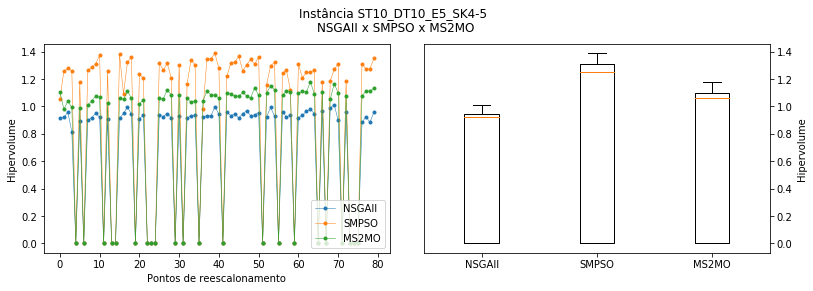

In [5]:
inst = "ST10_DT10_E5_SK4-5"
algorithms = ["NSGAII", "SMPSO", "MS2MO"]
datasets = [hv_event[inst][alg].hypervolume for alg in algorithms]
combined_plot_hv(hv_event, inst, algorithms)

In [6]:
stat, p = friedmanchisquare(*datasets)
print('Statistics=%.3f, p=%6E' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Mesmas distribuições (falhou em rejeitar H0)')
else:
    print('Distribuições diferentes (rejeitar H0)')


Statistics=112.138, p=4.462289E-25
Distribuições diferentes (rejeitar H0)


In [7]:
df = pd.DataFrame({alg: hv_event[inst][alg].hypervolume for alg in algorithms})
df = df.melt(var_name="algorithm", value_name="hypervolume")
pc = sp.posthoc_conover(df, group_col="algorithm", val_col="hypervolume")
pc

,MS2MO,NSGAII,SMPSO
MS2MO,-1.00E+00,8.34E-06,6.37E-05
NSGAII,8.34E-06,-1.00E+00,9.19E-16
SMPSO,6.37E-05,9.19E-16,-1.00E+00


(<matplotlib.axes._subplots.AxesSubplot at 0x114a331d0>,
 <matplotlib.colorbar.ColorbarBase at 0x1153c7a90>)

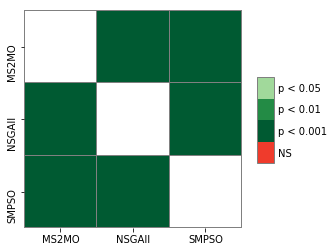

In [8]:
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(pc, **heatmap_args)

In [9]:
print("SMPSO  :", hv_event[inst]["SMPSO"].hypervolume.mean())
print("MS2MO  :", hv_event[inst]["MS2MO"].hypervolume.mean())
print("NSGA-II:", hv_event[inst]["NSGAII"].hypervolume.mean())

SMPSO  : 0.919454225
MS2MO  : 0.7825845924999999
NSGA-II: 0.6788378025


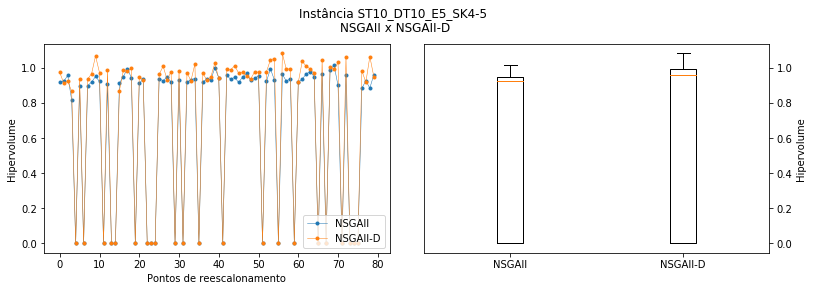

In [10]:
inst = "ST10_DT10_E5_SK4-5"
algorithms = ["NSGAII", "NSGAII-D"]
datasets = [hv_event[inst][alg].hypervolume for alg in algorithms]
combined_plot_hv(hv_event, inst, algorithms)

In [11]:
stat, p = wilcoxon(*datasets)
print('Statistics=%.3f, p=%6E' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Mesmas distribuições (falhou em rejeitar H0)')
else:
    print('Distribuições diferentes (rejeitar H0)')


Statistics=148.000, p=4.308626E-08
Distribuições diferentes (rejeitar H0)


In [12]:
df = pd.DataFrame({alg: hv_event[inst][alg].hypervolume for alg in algorithms})
df = df.melt(var_name="algorithm", value_name="hypervolume")
pc = sp.posthoc_conover(df, group_col="algorithm", val_col="hypervolume")
pc

,NSGAII,NSGAII-D
NSGAII,-1.00E+00,1.06E-03
NSGAII-D,1.06E-03,-1.00E+00


(<matplotlib.axes._subplots.AxesSubplot at 0x11550f390>,
 <matplotlib.colorbar.ColorbarBase at 0x11565b940>)

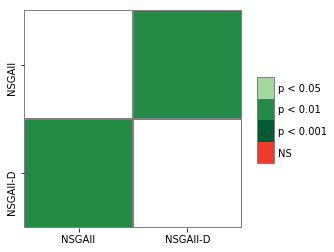

In [13]:
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(pc, **heatmap_args)

#### SMPSO x SMPSO Dinâmico

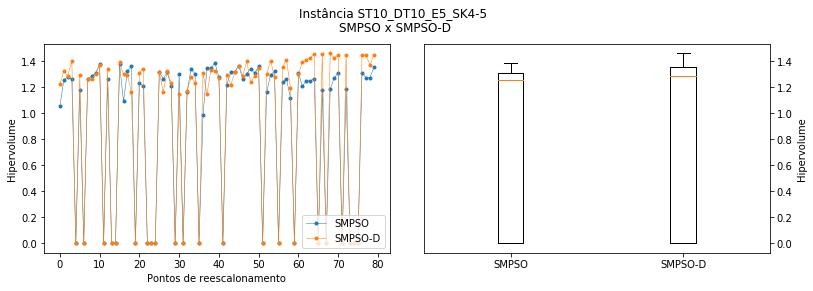

In [14]:
inst = "ST10_DT10_E5_SK4-5"
algorithms = ["SMPSO", "SMPSO-D"]
datasets = [hv_event[inst][alg].hypervolume for alg in algorithms]
combined_plot_hv(hv_event, inst, algorithms)

In [15]:
stat, p = wilcoxon(*datasets)
print('Statistics=%.3f, p=%6E' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Mesmas distribuições (falhou em rejeitar H0)')
else:
    print('Distribuições diferentes (rejeitar H0)')


Statistics=454.000, p=1.880061E-03
Distribuições diferentes (rejeitar H0)


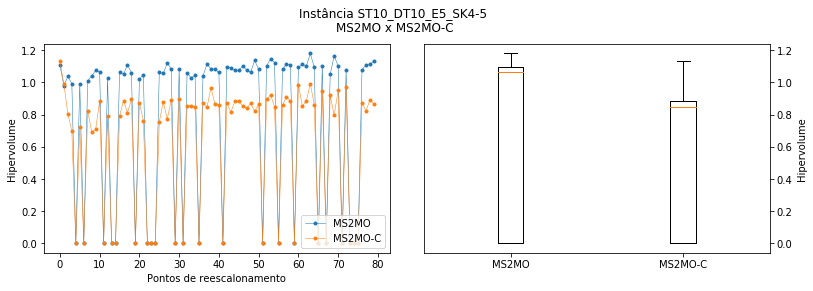

In [16]:
inst = "ST10_DT10_E5_SK4-5"
algorithms = ["MS2MO", "MS2MO-C"]
datasets = [hv_event[inst][alg].hypervolume for alg in algorithms]
combined_plot_hv(hv_event, inst, algorithms)

In [17]:
stat, p = wilcoxon(*datasets)
print('Statistics=%.3f, p=%6E' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Mesmas distribuições (falhou em rejeitar H0)')
else:
    print('Distribuições diferentes (rejeitar H0)')


Statistics=3.000, p=4.101836E-11
Distribuições diferentes (rejeitar H0)


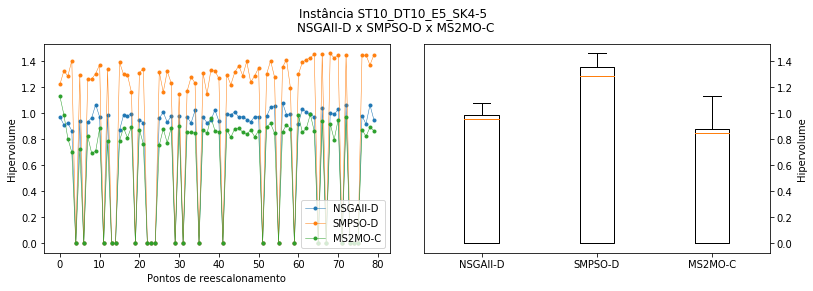

In [18]:
algorithms = ["NSGAII-D", "SMPSO-D", "MS2MO-C"]
datasets = [hv_event[inst][alg].hypervolume for alg in algorithms]
combined_plot_hv(hv_event, inst, algorithms)

In [19]:
stat, p = friedmanchisquare(*datasets)
print('Statistics=%.3f, p=%6E' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Mesmas distribuições (falhou em rejeitar H0)')
else:
    print('Distribuições diferentes (rejeitar H0)')


Statistics=108.552, p=2.680974E-24
Distribuições diferentes (rejeitar H0)


In [20]:
df = pd.DataFrame({alg: hv_event[inst][alg].hypervolume for alg in algorithms})
df = df.melt(var_name="algorithm", value_name="hypervolume")
pc = sp.posthoc_conover(df, group_col="algorithm", val_col="hypervolume")
pc

,MS2MO-C,NSGAII-D,SMPSO-D
MS2MO-C,-1.00E+00,3.34E-04,3.75E-15
NSGAII-D,3.34E-04,-1.00E+00,3.16E-06
SMPSO-D,3.75E-15,3.16E-06,-1.00E+00


(<matplotlib.axes._subplots.AxesSubplot at 0x115b1c7b8>,
 <matplotlib.colorbar.ColorbarBase at 0x115c977f0>)

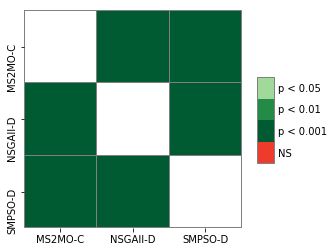

In [21]:
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(pc, **heatmap_args)

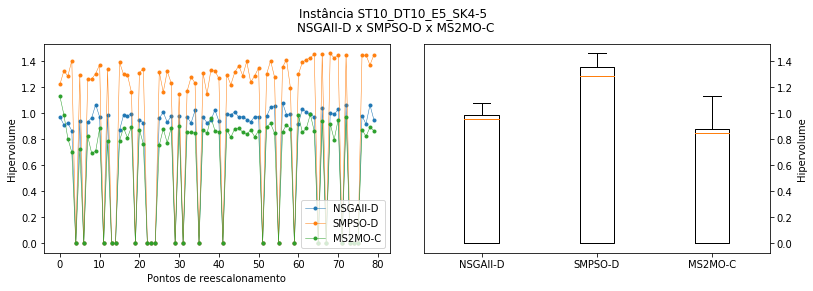

In [22]:
algorithms = ["NSGAII-D", "SMPSO-D", "MS2MO-C"]
datasets = [hv_event[inst][alg].hypervolume for alg in algorithms]
combined_plot_hv(hv_event, inst, algorithms)

**Comparações pareadas entre todos os algortimos**

In [36]:
pc = {}
algorithms = ["MS2MO", "MS2MO-C", "MS2MO-H", "MS2MO-P", "NSGAII", "NSGAII-D", "SMPSO", "SMPSO-D"]

In [37]:
inst = "ST10_DT10_E5_SK4-5"
datasets = [hv_event[inst][alg].hypervolume for alg in algorithms]
df = pd.DataFrame({alg: hv_event[inst][alg].hypervolume for alg in algorithms})
df = df.melt(var_name="algorithm", value_name="hypervolume")
pc[inst] = sp.posthoc_conover(df, group_col="algorithm", val_col="hypervolume")       

In [38]:
inst = "ST10_DT10_E15_SK4-5" 
datasets = [hv_event[inst][alg].hypervolume for alg in algorithms]
df = pd.DataFrame({alg: hv_event[inst][alg].hypervolume for alg in algorithms})
df = df.melt(var_name="algorithm", value_name="hypervolume")
pc[inst] = sp.posthoc_conover(df, group_col="algorithm", val_col="hypervolume")   

In [39]:
inst = "ST20_DT10_E5_SK4-5"
datasets = [hv_event[inst][alg].hypervolume for alg in algorithms]
df = pd.DataFrame({alg: hv_event[inst][alg].hypervolume for alg in algorithms})
df = df.melt(var_name="algorithm", value_name="hypervolume")
pc[inst] = sp.posthoc_conover(df, group_col="algorithm", val_col="hypervolume")   

,MS2MO,MS2MO-C,MS2MO-H,MS2MO-P,NSGAII,NSGAII-D,SMPSO,SMPSO-D
MS2MO,-1.00E+00,4.90E-09,1.76E-07,7.53E-08,9.78E-05,1.23E-02,2.21E-02,3.28E-03
MS2MO-C,4.90E-09,-1.00E+00,5.16E-01,6.24E-01,4.46E-02,6.59E-04,1.10E-15,6.62E-18
MS2MO-H,1.76E-07,5.16E-01,-1.00E+00,8.73E-01,1.74E-01,5.73E-03,1.27E-13,1.04E-15
MS2MO-P,7.53E-08,6.24E-01,8.73E-01,-1.00E+00,1.29E-01,3.48E-03,4.06E-14,3.08E-16
NSGAII,9.78E-05,4.46E-02,1.74E-01,1.29E-01,-1.00E+00,1.59E-01,9.32E-10,1.51E-11
NSGAII-D,1.23E-02,6.59E-04,5.73E-03,3.48E-03,1.59E-01,-1.00E+00,1.95E-06,6.78E-08
SMPSO,2.21E-02,1.10E-15,1.27E-13,4.06E-14,9.32E-10,1.95E-06,-1.00E+00,5.11E-01
SMPSO-D,3.28E-03,6.62E-18,1.04E-15,3.08E-16,1.51E-11,6.78E-08,5.11E-01,-1.00E+00


(<matplotlib.axes._subplots.AxesSubplot at 0x1154d9940>,
 <matplotlib.colorbar.ColorbarBase at 0x1154d30b8>)

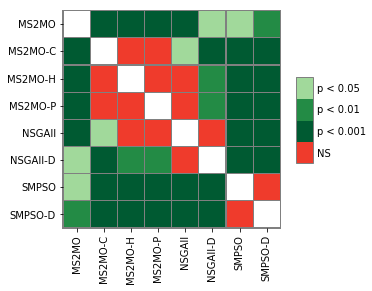

In [40]:
display(pc["ST10_DT10_E5_SK4-5"])
sp.sign_plot(pc["ST10_DT10_E5_SK4-5"], **heatmap_args)

,MS2MO,MS2MO-C,MS2MO-H,MS2MO-P,NSGAII,NSGAII-D,SMPSO,SMPSO-D
MS2MO,-1.00E+00,1.77E-40,2.23E-39,1.69E-53,1.04E-12,7.46E-19,3.16E-07,5.41E-21
MS2MO-C,1.77E-40,-1.00E+00,8.15E-01,8.23E-03,4.87E-12,3.25E-07,1.37E-66,7.73E-87
MS2MO-H,2.23E-39,8.15E-01,-1.00E+00,4.05E-03,2.26E-11,1.05E-06,2.38E-65,1.23E-85
MS2MO-P,1.69E-53,8.23E-03,4.05E-03,-1.00E+00,8.13E-21,2.31E-14,7.91E-81,1.71E-100
NSGAII,1.04E-12,4.87E-12,2.26E-11,8.13E-21,-1.00E+00,6.04E-02,6.07E-32,1.24E-51
NSGAII-D,7.46E-19,3.25E-07,1.05E-06,2.31E-14,6.04E-02,-1.00E+00,1.67E-40,9.76E-61
SMPSO,3.16E-07,1.37E-66,2.38E-65,7.91E-81,6.07E-32,1.67E-40,-1.00E+00,1.41E-06
SMPSO-D,5.41E-21,7.73E-87,1.23E-85,1.71E-100,1.24E-51,9.76E-61,1.41E-06,-1.00E+00


(<matplotlib.axes._subplots.AxesSubplot at 0x115de21d0>,
 <matplotlib.colorbar.ColorbarBase at 0x115af0828>)

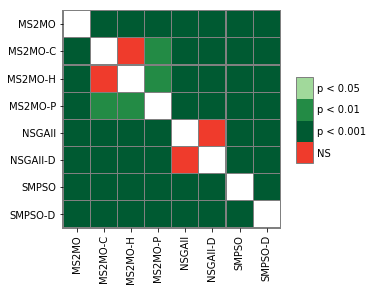

In [41]:
display(pc["ST10_DT10_E15_SK4-5"])
sp.sign_plot(pc["ST10_DT10_E15_SK4-5"], **heatmap_args)

,MS2MO,MS2MO-C,MS2MO-H,MS2MO-P,NSGAII,NSGAII-D,SMPSO,SMPSO-D
MS2MO,-1.00E+00,1.82E-16,1.72E-31,1.25E-17,3.66E-12,1.76E-04,1.88E-12,1.01E-09
MS2MO-C,1.82E-16,-1.00E+00,1.17E-04,7.33E-01,1.70E-01,3.37E-06,6.78E-47,4.07E-42
MS2MO-H,1.72E-31,1.17E-04,-1.00E+00,4.39E-04,2.07E-07,8.25E-17,8.61E-67,1.34E-61
MS2MO-P,1.25E-17,7.33E-01,4.39E-04,-1.00E+00,8.64E-02,6.37E-07,1.39E-48,9.31E-44
NSGAII,3.66E-12,1.70E-01,2.07E-07,8.64E-02,-1.00E+00,9.73E-04,2.86E-40,1.04E-35
NSGAII-D,1.76E-04,3.37E-06,8.25E-17,6.37E-07,9.73E-04,-1.00E+00,1.03E-25,7.37E-22
SMPSO,1.88E-12,6.78E-47,8.61E-67,1.39E-48,2.86E-40,1.03E-25,-1.00E+00,3.25E-01
SMPSO-D,1.01E-09,4.07E-42,1.34E-61,9.31E-44,1.04E-35,7.37E-22,3.25E-01,-1.00E+00


(<matplotlib.axes._subplots.AxesSubplot at 0x116031860>,
 <matplotlib.colorbar.ColorbarBase at 0x10ca02240>)

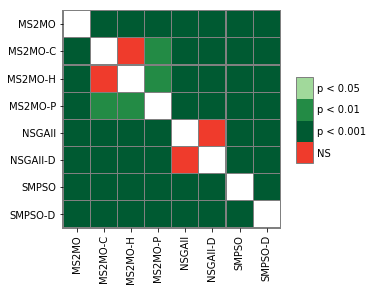

In [42]:
display(pc["ST20_DT10_E5_SK4-5"])
sp.sign_plot(pc["ST10_DT10_E15_SK4-5"], **heatmap_args)

### QP3: Influência de cada estratégia heurística dinâmica

In [ ]:
algorithms = ["MS2MO-C", "MS2MO-P", "MS2MO-H"]
datasets = [hv_event[inst][alg].hypervolume for alg in algorithms]
combined_plot_hv(hv_event, inst, algorithms)

In [ ]:
stat, p = friedmanchisquare(*datasets)
print('Statistics=%.3f, p=%6E' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Mesmas distribuições (falhou em rejeitar H0)')
else:
    print('Distribuições diferentes (rejeitar H0)')

In [ ]:
df = pd.DataFrame({alg: hv_event[inst][alg].hypervolume for alg in algorithms})
df = df.melt(var_name="algorithm", value_name="hypervolume")
pc = sp.posthoc_conover(df, group_col="algorithm", val_col="hypervolume")
pc

In [ ]:
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(pc, **heatmap_args)

In [ ]:
inst = "ST10_DT10_E15_SK4-5"
datasets = [hv_event[inst][alg].hypervolume for alg in algorithms]
combined_plot_hv(hv_event, inst, algorithms)